# Chapter 7. 합성곱 신경망(CNN)
## 7.4 합성곱/풀링 계층 구현하기
### 7.4.1 4차원 배열
- CNN에서 계층 사이를 흐르는 데이터는 4차원이다.
- 데이터의 형상이 (10, 1, 28, 28) <=> 높이 28, 너비 28, 채널 1개인 데이터가 10개

In [1]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)  # 무작위로 데이터 생성
print(x.shape)

# 10개 중 1, 2번째 데이터 접근
print(x[0].shape)
print(x[1].shape)

# 1번째 데이터의 첫 채널의 공간 데이터 접근
print(x[0, 0])  # x[0][0]

(10, 1, 28, 28)
(1, 28, 28)
(1, 28, 28)
[[1.57706991e-01 8.98790795e-01 2.85823534e-01 3.88399708e-01
  3.97616408e-01 5.82295403e-03 4.01014326e-01 2.01369028e-01
  6.04078238e-01 6.74973870e-02 1.75184591e-02 7.45330274e-01
  9.71720675e-01 3.89880507e-01 6.18780812e-01 4.85203735e-03
  9.06857282e-01 2.67967322e-01 3.77579264e-01 6.19436110e-01
  5.52654982e-01 3.03512129e-01 5.11215356e-01 7.95906720e-01
  5.40470088e-01 4.49971077e-01 9.00442884e-01 1.75352491e-01]
 [7.39450198e-01 4.09132582e-01 9.45678816e-01 2.93107265e-01
  1.71237586e-01 4.49829835e-01 9.35450601e-01 5.60695852e-01
  4.09550917e-02 1.44466644e-01 5.16126540e-01 6.30006943e-01
  8.41747635e-01 5.29903597e-01 8.55798476e-01 8.25244792e-01
  8.50611188e-01 3.85217912e-01 8.26812911e-01 6.65716483e-01
  8.02429851e-01 5.01158439e-01 4.20492556e-01 2.17581679e-01
  4.20369854e-01 3.46909870e-01 2.28514428e-01 7.16026350e-01]
 [3.35235909e-01 4.43435045e-01 8.50900704e-01 4.90644712e-01
  2.79865589e-01 7.99747509e

### 7.4.2 im2col로 데이터 전개하기
- 합성곱 연산에서 for문을 중첩해 사용하면 성능이 떨어진다는 단점 -> for문 대신 im2col 사용
- **im2col**
    - 입력 데이터를 필터링(가중치 계산) 하기 좋게 전개하는 함수
    - 입력 데이터에서 필터를 적용하는 영역을 한 줄로 늘어놓는다. 이 전개를 모든 영역에서 수행

![image](https://user-images.githubusercontent.com/61455647/116519890-fa5c8080-a90c-11eb-9831-6b8531b59716.png)

- 예시에서는 스트라이드를 크게 잡아 필터의 적용 영역이 겹치지 않았지만, 실제로는 겹치는 경우가 많다. 필터 적용 영역이 겹치면 im2col로 전개한 후 원소 수가 원래 블록의 원소 수보다 많아진다. -> 메모리를 더 많이 사용한다는 단점이 있지만, 컴퓨터는 큰 행렬을 묶어 계산하는 데 탁월하기 때문에 행렬 계산으로 만들면 선형 대수 라이브러리로 효율을 높일 수 있다.

![image](https://user-images.githubusercontent.com/61455647/116534150-241da380-a91d-11eb-8967-7eea526e1fb1.png)

- 합성곱 연산의 필터 처리 과정: 필터를 세로로 1열로 전개하고, im2col이 전개한 데이터와 행렬 곱을 계산해 출력 데이터를 reshape

### 7.4.3 합성곱 계층 구현하기

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

- `im2col(input_data, filter_h, filter_w, stride=1, pad=0)`:
    - `input_data`: (데이터 수, 채널 수, 높이, 너비)의 4차원 배열로 이루어진 입력 데이터
    - `filter_h`: 필터의 높이
    - `filter_w`: 필터의 너비
    - `stride`: 스트라이드
    - `pad`: 패딩

In [3]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)  # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)  # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


- 1번째 예시: 배치 크기가 1, 채널 3개, 높이/너비가 7*7인 데이터
- 2번째 예시: 배치 크기가 10, 채널 3개, 높이/너비가 7*7인 데이터
- im2col 함수를 적용했을 때 2번째 차원의 원소는 75개 = 필터의 원소 수(채널 3개, 5*5 데이터)

In [4]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

- 필터 `(FN, C, FH, FW)`: (필터 개수, 채널, 필터 높이, 필터 너비)
- `col = im2col(x, FH, FW, self.stride, self.pad)`~`out = np.dot(col, col_W) + self.b`
    - 입력 데이터를 `im2col`로 전개 -> 필터도 `reshape()`로 2차원 배열로 전개 -> 전개한 두 행렬의 곱
    - `reshape( , -1)`: 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되도록 적절히 묶음
- `transpose()`: 다차원 배열의 축 순서를 바꿔주는 함수, 인덱스를 지정하여 축의 순서 변경

![image](https://user-images.githubusercontent.com/61455647/116537604-6a750180-a921-11eb-84b2-5fdd002b39f4.png)

- 합성곱 계층의 역전파는 Affine 계층과 똑같지만, `im2col`을 역으로 처리해야 한다. -> `col2im` 함수 사용

### 7.4.4 풀링 계층 구현하기
- 풀링은 채널이 독립적이라는 점이 합성곱 계층 때와 다르다.

![image](https://user-images.githubusercontent.com/61455647/116538055-0141be00-a922-11eb-94b2-c9ad878fb4cb.png)

- 입력 데이터의 풀링 적용 영역을 전개한 후 행렬에서 행별 최대값을 구하고, 적절한 형상으로 성형하면 된다.

![image](https://user-images.githubusercontent.com/61455647/116538262-4239d280-a922-11eb-8b4d-8632af95ecb0.png)

In [5]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 1. 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 2. 최대값
        out = np.max(col, axis=1)
        
        # 3. 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

- 풀링 계층 구현 단계
    1. 입력 데이터를 전개한다.
    2. 행별 최대값을 구한다.
    3. 적절한 모양으로 성형한다.
- `np.max(x, axis=1)`: 입력 x의 1번째 차원의 축마다 최대값

## 7.5 CNN 구현하기

![image](https://user-images.githubusercontent.com/61455647/116541855-f178a880-a926-11eb-93e2-53c936024ba1.png)

- Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax 순의 CNN 네트워크

In [6]:
import sys, os
sys.path.append(os.pardir)
from common.layers import *
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1}, hidden_size=100, output_size=10, weight_init_std=0.01):
        # 하이퍼파라미터를 딕셔너리에서 꺼내고 합성곱 계층의 출력 크기 계산
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
        
        # 가중치 매개변수 초기화
        self.params = {}
        # 1번째 계층: 합성곱 계층
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        # 2, 3번째 계층: 완전연결 계층
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    # 오차역전파법으로 기울기 구하기
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    # 출처: https://github.com/oreilly-japan/deep-learning-from-scratch/blob/5aebd992ef70f8e0caa1036045eff53ce801e16b/ch07/simple_convnet.py
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

- 초기화 때 받는 인수
    - `input_dim`: 입력 데이터(채널 수, 높이, 너비)의 차원
    - `conv_param`: 합성곱 계층의 하이퍼파라미터(딕셔너리)
        - `filter_num`: 필터 수
        - `filter_size`: 필터 크기
        - `stride`: 스트라이드
        - `pad`: 패딩
    - `hidden_size`: 은닉층(완전연결)의 뉴런 수
    - `output_size`: 출력층(완전연결)의 뉴런 수
    - `weight_init_std`: 초기화 때의 가중치 표준편차
- `predict()`: 추론 수행, 초기화 때 `layers`에 추가한 계층을 맨 앞에서부터 차례로 `forward()`를 호출해 결과를 다음 계층에 전달
- `loss()`
    - 손실 함수
    - `predict()`의 결과를 인수로 마지막 층의 `forward()` 호출

In [7]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 처리에 시간이 걸릴 때 데이터 일부로만 실행
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.3001593827322955
=== epoch:1, train acc:0.285, test acc:0.281 ===
train loss:2.2979991193891145
train loss:2.2924430551858803
train loss:2.2866418021868675
train loss:2.272355069154025
train loss:2.258468138514817
train loss:2.2518315732674274
train loss:2.237582805636147
train loss:2.2200888431724835
train loss:2.1726844083606744
train loss:2.1325225975488085
train loss:2.115424308453094
train loss:2.0273107230233887
train loss:1.9407961304463308
train loss:1.9761550038615954
train loss:1.8523726594079257
train loss:1.7164817842069817
train loss:1.7214057722302811
train loss:1.6965727668626167
train loss:1.4335727056417829
train loss:1.5669094123072689
train loss:1.4489663279197647
train loss:1.3099586352003703
train loss:1.1415367056116978
train loss:1.1368459309609336
train loss:1.068221663050502
train loss:1.130721353428072
train loss:0.9160238691583515
train loss:1.0744887308160374
train loss:0.9028979186853111
train loss:0.8561687144978875
train loss:0.76027094777872

train loss:0.21012679369256926
train loss:0.285254175200184
train loss:0.08985662886893943
train loss:0.2514688781724496
train loss:0.18164228389083148
train loss:0.28909485291595477
train loss:0.3470078426810035
train loss:0.25508262779279905
train loss:0.24373895596549794
train loss:0.2244734632156435
train loss:0.1806336267092618
train loss:0.12666321364645294
train loss:0.07066955790102683
train loss:0.25582447785734513
train loss:0.12248962976781617
train loss:0.2556789521087834
train loss:0.23995991154550073
train loss:0.20988265304984238
train loss:0.3230951203746133
train loss:0.1561503253663963
train loss:0.29685409498373133
train loss:0.31536049072775096
train loss:0.10803006790225192
train loss:0.2247211533173582
train loss:0.20672874235231403
train loss:0.24696681067798262
train loss:0.20947823964228857
train loss:0.36025152672706007
train loss:0.16940577199351017
train loss:0.18381334967891338
train loss:0.20400557309275397
train loss:0.24267343314714399
train loss:0.12724

train loss:0.2511777372199403
train loss:0.10026022350756429
train loss:0.03890509036993649
train loss:0.10227587877907254
train loss:0.12865426263038937
train loss:0.07094891085201854
train loss:0.058176479168083634
train loss:0.11920103988554445
train loss:0.07936870315416354
train loss:0.17487882165303617
train loss:0.10782946912830967
train loss:0.1845631282865813
train loss:0.09707503905165471
train loss:0.11233274715240679
train loss:0.22903309367856392
train loss:0.0968694600212004
train loss:0.12161710409192895
train loss:0.0865721810449487
train loss:0.07314456540961957
train loss:0.07263668157117419
train loss:0.10360248912984968
train loss:0.21679861250063617
train loss:0.09785649339079945
train loss:0.09017215935858833
train loss:0.23003961145870944
train loss:0.15017650957177925
train loss:0.11925421958485583
train loss:0.08164906600661237
train loss:0.13100253457262906
train loss:0.09507505972119773
train loss:0.06737355743125187
train loss:0.06532515864900498
train loss:

train loss:0.04996102903449907
train loss:0.02304857257644712
train loss:0.11260187358758277
train loss:0.13539621345149136
train loss:0.19877899669484797
train loss:0.09868597823487985
train loss:0.03845290995987422
train loss:0.0453120879173101
train loss:0.051250923587850696
train loss:0.08116414324167519
train loss:0.04234316332476881
train loss:0.05159974558031056
train loss:0.1728414884850514
train loss:0.040690738389579914
train loss:0.058419363209725565
train loss:0.08075227768195722
train loss:0.054521229714388816
train loss:0.06527457370374452
train loss:0.04231134303224964
train loss:0.14163353028475184
train loss:0.13983319835835073
train loss:0.14668088521510295
train loss:0.04116607871425449
train loss:0.09749320072223294
train loss:0.04065875257294028
train loss:0.12242718875721614
train loss:0.05816051846953792
train loss:0.0998876415996124
train loss:0.034917224393866665
train loss:0.09504662554533348
train loss:0.1168540889360073
train loss:0.11196385701242109
train l

train loss:0.055086405120240885
train loss:0.09367995450799156
train loss:0.11414758659375522
train loss:0.07893256261947144
train loss:0.06593087482001886
train loss:0.02895128298834534
train loss:0.02675541734517941
train loss:0.041012545716175984
train loss:0.14305420718231707
train loss:0.07483680293579684
train loss:0.047984495658938295
train loss:0.013518727032164892
train loss:0.05253461867845319
train loss:0.03026024636903112
train loss:0.038484488188602076
train loss:0.1567308615701971
train loss:0.05283403994214332
train loss:0.1250644018892787
train loss:0.05089605324925066
train loss:0.04735725441921129
train loss:0.04653096091442497
train loss:0.0593079206830725
train loss:0.042464537760389096
train loss:0.06502758454246046
train loss:0.024016989313284297
train loss:0.18321093376976336
train loss:0.05743064422333016
train loss:0.01818611031276616
train loss:0.06230872169262838
train loss:0.03375214161730204
train loss:0.070209877671235
train loss:0.09975664147997908
train 

train loss:0.03998919793162755
train loss:0.057882670066843236
train loss:0.03395352178457062
train loss:0.0736680525221542
train loss:0.019314406976235134
train loss:0.05028488436129052
train loss:0.04719401378688057
train loss:0.02291506696714905
train loss:0.011144965525251675
train loss:0.02635778982804231
train loss:0.04313643661078768
train loss:0.03123081236278427
train loss:0.023296711422843567
train loss:0.021063175334459446
train loss:0.06012994685771938
train loss:0.08159560907944512
train loss:0.015527620900035557
train loss:0.04216700298115254
train loss:0.060992161741164334
train loss:0.03244432659248962
train loss:0.041497979979893546
train loss:0.04177688364496166
train loss:0.06491890249935921
train loss:0.02621957316702648
train loss:0.037838247828807264
train loss:0.022015948393789144
train loss:0.07111292967947777
train loss:0.028147485017983045
train loss:0.04050382447517288
train loss:0.1566252395554475
train loss:0.034004404502884895
train loss:0.0504840443895655

train loss:0.024966645753078248
train loss:0.03882441299863976
train loss:0.1664149293169586
train loss:0.02977366083169034
train loss:0.03838704488114413
train loss:0.06396289886597152
train loss:0.008459639487881391
train loss:0.018135366176833055
train loss:0.007783868938446922
train loss:0.043443815101438805
train loss:0.04576124979320707
train loss:0.06239691648391932
train loss:0.033166844150321666
train loss:0.00954811933694588
train loss:0.034246745388102816
train loss:0.06527255456664553
train loss:0.033275496432284085
train loss:0.03747566890984525
train loss:0.010669903931040465
train loss:0.03252110547146633
train loss:0.06286859596695896
train loss:0.025979694895848976
train loss:0.024638335935615277
train loss:0.05625529019898887
train loss:0.08281117275628956
train loss:0.09698312177887138
train loss:0.013216690213860172
train loss:0.0876570349474793
train loss:0.05858757978566415
train loss:0.027283489988825287
train loss:0.06960032083096583
train loss:0.041785428042972

train loss:0.014312112963376694
train loss:0.013916588753247456
train loss:0.04114959193930356
train loss:0.018563179947164492
train loss:0.03320038596716802
train loss:0.048990772785480835
train loss:0.08200496764306424
train loss:0.049832281726933124
train loss:0.06795214900455929
train loss:0.01563037306840591
train loss:0.04089530992506958
train loss:0.008927559221355045
train loss:0.03428931521851968
train loss:0.027368495776879945
train loss:0.029586519075442547
train loss:0.024364845414624945
train loss:0.19098491313394914
train loss:0.020087413307364504
train loss:0.018417325402833033
train loss:0.008425596814447087
train loss:0.01805480965903317
train loss:0.027914436437216958
train loss:0.06896277210697398
train loss:0.029368332298407678
train loss:0.05804053481068796
train loss:0.03314733713553011
train loss:0.04280349503975004
train loss:0.03311109244013086
train loss:0.029748541201128534
train loss:0.053340862356354185
train loss:0.010759379148503216
train loss:0.015769598

train loss:0.015426263492655272
train loss:0.042825941764285426
train loss:0.01790017877556698
train loss:0.02611524794925481
train loss:0.034853915518617926
train loss:0.04285004388503678
train loss:0.012215710483490962
train loss:0.01391955334986591
train loss:0.011422133412271766
train loss:0.010121075909794754
train loss:0.026844079226568413
train loss:0.01722788906503492
train loss:0.08443896456353349
train loss:0.0059799921739049945
train loss:0.05767837618675856
train loss:0.027049932859295897
train loss:0.03427265949906211
train loss:0.02785545495985616
train loss:0.020390705782241475
train loss:0.015173184429290594
train loss:0.01525290253872388
train loss:0.060748437841762384
train loss:0.03308627214330856
train loss:0.016529811306222653
train loss:0.08034737866999342
train loss:0.09337786496589065
train loss:0.028150410022436935
train loss:0.017614312260548593
train loss:0.05082953477054025
train loss:0.08591602018907826
train loss:0.026808000758221286
train loss:0.073933859

train loss:0.005220236402366751
train loss:0.01461210245947747
train loss:0.011628992526457313
train loss:0.0476289750172054
train loss:0.025692735903949583
train loss:0.028239560496131334
train loss:0.026127518522459616
train loss:0.00836147938671319
train loss:0.008217908794452562
train loss:0.004369397434166865
train loss:0.06049106778501806
train loss:0.014759117164822427
train loss:0.01794401801253088
train loss:0.028186518004355593
train loss:0.0266629899070679
train loss:0.012886001108748999
train loss:0.012926104582712896
train loss:0.01667433680863336
train loss:0.015074797692384755
train loss:0.04497387016759305
train loss:0.026142715663952872
train loss:0.006145703848072511
train loss:0.0098110099893905
train loss:0.02240160296034183
train loss:0.04194693182719044
train loss:0.01938985910688863
train loss:0.026703306483650636
train loss:0.008566460027477525
train loss:0.05198446529408693
=== epoch:5, train acc:0.985, test acc:0.978 ===
train loss:0.01630329020637853
train lo

train loss:0.21320855677997025
train loss:0.014031870164142743
train loss:0.028174647450113496
train loss:0.05258976532182851
train loss:0.019075688384846943
train loss:0.007186956537734947
train loss:0.017592699823997776
train loss:0.017351536099047295
train loss:0.03061236074904643
train loss:0.028497607929377847
train loss:0.011707646584413067
train loss:0.044726124112629814
train loss:0.012137247834673933
train loss:0.003533536680684506
train loss:0.004813092782845251
train loss:0.01878980257135193
train loss:0.035228520245718487
train loss:0.010077349669799356
train loss:0.008431374312492353
train loss:0.009181411247804298
train loss:0.039933938177407875
train loss:0.06480563953964136
train loss:0.014293910381205099
train loss:0.012942559232261659
train loss:0.08183237989751058
train loss:0.07205892302309919
train loss:0.04403580925080997
train loss:0.042863904555062005
train loss:0.007360042505480108
train loss:0.025362965286237917
train loss:0.08281354619891157
train loss:0.0055

train loss:0.009409392725419597
train loss:0.010404641508471178
train loss:0.006420527653659038
train loss:0.0723452474397678
train loss:0.006027956789264154
train loss:0.027376935950739797
train loss:0.0016184328926041713
train loss:0.007079871925075978
train loss:0.00884236144032319
train loss:0.05261696528488122
train loss:0.026456338977058437
train loss:0.009191122777951638
train loss:0.10343768716689511
train loss:0.005764245285961773
train loss:0.012522331739816275
train loss:0.007535574881243408
train loss:0.010677876045675983
train loss:0.00965262976004616
train loss:0.034704548027388024
train loss:0.01195024549858595
train loss:0.02519999977584353
train loss:0.008769180908339686
train loss:0.011036863296875357
train loss:0.009476670326494017
train loss:0.01270946651713253
train loss:0.06277683812423066
train loss:0.003374514841861105
train loss:0.03155585530984487
train loss:0.009308463072320382
train loss:0.02014188986397403
train loss:0.024640636130562887
train loss:0.001512

train loss:0.00447760689904772
train loss:0.01536540079727158
train loss:0.022721614127185166
train loss:0.01548361113182716
train loss:0.008805529322376245
train loss:0.011058199159421822
train loss:0.00942628318197754
train loss:0.01589349494197642
train loss:0.023333405506672063
train loss:0.007444335832008664
train loss:0.013609225824215594
train loss:0.013236634856470853
train loss:0.03738847528484127
train loss:0.0034354604963974748
train loss:0.012598604072010966
train loss:0.01586084415736284
train loss:0.010422168167731092
train loss:0.0345526575429307
train loss:0.006766410404314459
train loss:0.016978898811756956
train loss:0.017742453871371022
train loss:0.007520644297280855
train loss:0.007535622720660685
train loss:0.023528527868462698
train loss:0.005808806121694776
train loss:0.03350981472285594
train loss:0.009100966098887945
train loss:0.028163016784165974
train loss:0.01368533731860793
train loss:0.016699128120554595
train loss:0.00844031919843803
train loss:0.030694

train loss:0.008140546227591498
train loss:0.003247739287642786
train loss:0.011492300375375228
train loss:0.01581344035249521
train loss:0.02527432090504934
train loss:0.01716968968782561
train loss:0.008951650369297393
train loss:0.002730972134967765
train loss:0.16915083254845456
train loss:0.010553459646063395
train loss:0.012317528213506623
train loss:0.006192877893317322
train loss:0.0053951702231384655
train loss:0.02274530074369566
train loss:0.030365104477118425
train loss:0.04424123636082034
train loss:0.01042356659819645
train loss:0.012787671355388355
train loss:0.02373543200342164
train loss:0.02078312328026143
train loss:0.003204327802114274
train loss:0.016008683737043113
train loss:0.0018812637965842536
train loss:0.016415781762466334
train loss:0.01165857569728744
train loss:0.021371044353764638
train loss:0.01793926293496174
train loss:0.004605327686424518
train loss:0.018549571657121355
train loss:0.012240775623220299
train loss:0.06255527610604589
train loss:0.03166

train loss:0.1118585655014753
train loss:0.007471895875868055
train loss:0.028870598356676925
train loss:0.02039284929364923
train loss:0.004648941150097144
train loss:0.014903244295961314
train loss:0.024778307567156467
train loss:0.014827131435234705
train loss:0.005568386621798037
train loss:0.028019431364198426
train loss:0.0683348762754939
train loss:0.008817598710263903
train loss:0.004119549202770195
train loss:0.021752681080718997
train loss:0.001960557679041751
train loss:0.036980478475906915
train loss:0.00918503473864644
train loss:0.009001788579743117
train loss:0.06743632669787378
train loss:0.11288263159031993
train loss:0.025613577137981864
train loss:0.07613230664319136
train loss:0.007368257827577743
train loss:0.015100681677469044
train loss:0.03946952608522951
train loss:0.02896975823625863
train loss:0.08100608689123376
train loss:0.0365706114346058
train loss:0.0073560351653603724
train loss:0.005537372853700463
train loss:0.005044176347126145
train loss:0.00829259

train loss:0.0015683391304601325
train loss:0.004219118843186862
train loss:0.024234325601452684
train loss:0.04899046352219918
train loss:0.006360115309668543
train loss:0.040687912245359045
train loss:0.0069072842919974805
train loss:0.005150533231249485
train loss:0.0011508131706483458
train loss:0.022621917958586812
train loss:0.004478069594810752
train loss:0.015331620504092229
train loss:0.019662005748361435
train loss:0.010467433013509064
train loss:0.01318781037434509
train loss:0.003662016937654534
train loss:0.009345586581676859
train loss:0.010413583233048211
train loss:0.008780694646846438
train loss:0.013712759402879466
train loss:0.01689175424824753
train loss:0.012033101639250391
train loss:0.008562970179088783
train loss:0.009971700558774084
train loss:0.008761529508478028
train loss:0.013472844836436617
train loss:0.012422481414400135
train loss:0.018068256272144728
train loss:0.005297835708504778
train loss:0.00893223214424161
train loss:0.005081750739437655
train los

train loss:0.0315211219783167
train loss:0.008591950858447637
train loss:0.0048310771267119695
train loss:0.004036882370393204
train loss:0.05943479797617547
train loss:0.04247005444051087
train loss:0.0013310951326617612
train loss:0.005659487098995566
train loss:0.009571880965178258
train loss:0.0010062303454342711
train loss:0.012495384144284971
train loss:0.004698237894832174
train loss:0.018149950926649262
train loss:0.005640492946591119
train loss:0.006231353040902773
train loss:0.008504175315904012
train loss:0.004896460944936364
train loss:0.0023668264315854
train loss:0.0024394019277095363
train loss:0.021051799136422505
train loss:0.01321991352640362
=== epoch:8, train acc:0.99, test acc:0.982 ===
train loss:0.011248444181196153
train loss:0.013368379877407965
train loss:0.02717340059015545
train loss:0.018503302332889538
train loss:0.003118339893988972
train loss:0.0046300476164636865
train loss:0.013518374862574132
train loss:0.032900081677818854
train loss:0.01906857144359

train loss:0.006396599117870866
train loss:0.007944426884043043
train loss:0.005417746481128028
train loss:0.008023162725918812
train loss:0.01022831464282273
train loss:0.007404590300950075
train loss:0.006971141487968031
train loss:0.0025977640969017095
train loss:0.0025211192603299365
train loss:0.07407421241894763
train loss:0.006572016644369031
train loss:0.0010236545450719677
train loss:0.016049014500910855
train loss:0.0034654015533284355
train loss:0.004104996547532834
train loss:0.00954565757426323
train loss:0.004881967609584113
train loss:0.011009611188741894
train loss:0.0021668735186970286
train loss:0.008297169854538653
train loss:0.005378648031640277
train loss:0.008938300832018268
train loss:0.005409227160920591
train loss:0.0007037530952752772
train loss:0.006888523111307994
train loss:0.0077415490021914505
train loss:0.0006633859732341143
train loss:0.005311505159897888
train loss:0.0030238122778117353
train loss:0.0079478455994541
train loss:0.00479631459525979
train

train loss:0.06628571970084259
train loss:0.003006598432676523
train loss:0.005606431288693834
train loss:0.022117525320132433
train loss:0.00870474035741955
train loss:0.0013959332872677227
train loss:0.008087398474933373
train loss:0.014632125172780026
train loss:0.010632370954560502
train loss:0.006199804101508619
train loss:0.005867669247849667
train loss:0.025655612366987247
train loss:0.023027719782530293
train loss:0.04675345602050898
train loss:0.010631376768632095
train loss:0.003508923963938222
train loss:0.010159562837389216
train loss:0.015222759025931575
train loss:0.002771811799363341
train loss:0.00489080436673376
train loss:0.0013072761759357918
train loss:0.004872857429414363
train loss:0.014670934403625874
train loss:0.004199259657833526
train loss:0.016063155640275665
train loss:0.0015159298352515895
train loss:0.006238035094010216
train loss:0.003919869248304446
train loss:0.006537033412944366
train loss:0.0012028696830962864
train loss:0.005874469574313399
train lo

train loss:0.0009444248714196965
train loss:0.004639632859358186
train loss:0.01510868508748668
train loss:0.01717546390372114
train loss:0.01771448414820771
train loss:0.004715948013242281
train loss:0.003302607315632682
train loss:0.0019574519426093563
train loss:0.006347688223864036
train loss:0.007230770015083889
train loss:0.034415972112605636
train loss:0.03543430008201405
train loss:0.011997612949867183
train loss:0.021628175167763247
train loss:0.004085637838885651
train loss:0.004557291992199574
train loss:0.007542072200461468
train loss:0.005399623894701243
train loss:0.012599156994954435
train loss:0.00676388266745223
train loss:0.008164264838569886
train loss:0.002505551548649587
train loss:0.01559253442699366
train loss:0.007175182470170907
train loss:0.0030341805709365455
train loss:0.003123078127123969
train loss:0.006223922845850266
train loss:0.013667678315316711
train loss:0.00228556674765148
train loss:0.009885551869632931
train loss:0.0036808779006608206
train loss:

train loss:0.009306654693102214
train loss:0.0030880639473155696
train loss:0.0012465936475274844
train loss:0.007588321126602122
train loss:0.009986436311974716
train loss:0.0016469652767345253
train loss:0.006018930508743746
train loss:0.011025565486166735
train loss:0.05651888814801888
train loss:0.0006288892838502745
train loss:0.04085575468664638
train loss:0.0028199683038032074
train loss:0.0016489726655272482
train loss:0.0008991232804718454
train loss:0.001551028977338358
train loss:0.008407452365705972
train loss:0.004309602535193611
train loss:0.009750706929413645
train loss:0.004132039666164033
train loss:0.025744875220781394
train loss:0.0035983872467334668
train loss:0.00937376298720412
train loss:0.006201852128864094
train loss:0.001881527438626874
train loss:0.005104877095876996
train loss:0.004141968165643209
train loss:0.00042523114641559496
train loss:0.006551950764199561
train loss:0.04203154826862259
train loss:0.003208531563883877
train loss:0.007236931087812373
tr

train loss:0.002926021777008333
train loss:0.02255105386745836
train loss:0.010031012450142296
train loss:0.0014637133036176724
train loss:0.0032908167514179632
train loss:0.0036895195772955313
train loss:0.0031279648496966707
train loss:0.004230713104952634
train loss:0.006019215795228166
train loss:0.006010221102165935
train loss:0.005194753143688685
train loss:0.003212067657227345
train loss:0.010580480533051757
train loss:0.0023444551177998867
train loss:0.0281216859162649
train loss:0.012919205913918978
train loss:0.0060914124860713195
train loss:0.0037172150119658427
train loss:0.00205945080459163
train loss:0.000974463743937175
train loss:0.0037166719040624525
train loss:0.001143560965532354
train loss:0.01004657645694219
train loss:0.001481293185770609
train loss:0.0018124320390635858
train loss:0.006355965066266094
train loss:0.004535351133678276
train loss:0.002345328577743646
train loss:0.0009499643331389526
train loss:0.001468577107852773
train loss:0.0027365296693654976
tr

train loss:0.002955684677906404
train loss:0.0035570890548127605
train loss:0.0008889110584304084
train loss:0.0017985958950172945
train loss:0.004476468108144752
train loss:0.008059821887458463
train loss:0.012249847663934775
train loss:0.0010799073672725736
train loss:0.001481279823319995
train loss:0.004365246365298953
train loss:0.03453068957334052
train loss:0.013250445478874183
train loss:0.1672455829426353
train loss:0.0037256885042667547
train loss:0.003387214879701321
train loss:0.0010270859882618838
train loss:0.011043945404991241
train loss:0.00496917798823978
train loss:0.005366976979929771
train loss:0.0011176555189022193
train loss:0.00040731578944694006
train loss:0.0064437739563080985
train loss:0.0020369470705794233
train loss:0.011417265487334172
train loss:0.00374237628797495
train loss:0.0050151501950970725
train loss:0.011006945315376541
train loss:0.008610060152918908
train loss:0.001868780534093617
train loss:0.00673751817469379
train loss:0.010778402916580675
tr

train loss:0.009268512240675346
train loss:0.001545450326609789
train loss:0.0036930097778170644
train loss:0.001734707613626474
train loss:0.0054121406394027705
train loss:0.002467187502237605
train loss:0.0005796494057354379
train loss:0.007573788124978592
train loss:0.01867108966688056
train loss:0.003216405866170726
train loss:0.009328269887521078
train loss:0.0041152573795880465
train loss:0.004081694245451877
train loss:0.005295417394526377
train loss:0.009442319381692047
train loss:0.0031111043003854573
train loss:0.0013101566594679217
train loss:0.005198075711168126
train loss:0.006198662547122752
train loss:0.030802774793489328
train loss:0.003032494648014391
train loss:0.0002685896479722288
train loss:0.0008405958288267515
train loss:0.009192488903450842
train loss:0.004253757709868431
train loss:0.001356127735648259
train loss:0.008586205988945203
train loss:0.054064191635438685
train loss:0.009987710123817094
train loss:0.0021549999921131563
train loss:0.0014124996991082494

train loss:0.0023988343096588275
train loss:0.0020991300780143643
train loss:0.002429799300369338
train loss:0.00018357023303709999
train loss:0.0035640565905000533
train loss:0.002868777844914844
train loss:0.004437968347033778
train loss:0.0025424065221444437
train loss:0.012915907397007497
train loss:0.0013848992537907263
train loss:0.0004513198029413433
train loss:0.04789844155613784
train loss:0.002980410894701472
train loss:0.0021521063093399634
train loss:0.0029492796404153405
train loss:0.0008374163624295968
train loss:0.0018203560739868162
train loss:0.0029941845080443045
train loss:0.02577973485540601
train loss:0.027740942627338366
train loss:0.030317880513728423
train loss:0.0006521596040121884
train loss:0.0028792471042095895
train loss:0.003427190128378875
train loss:0.010059923975098544
train loss:0.010270507603543618
train loss:0.0018175542342532241
train loss:0.0041885163407294175
train loss:0.0033129444575428885
train loss:0.0007442494016243653
train loss:0.0002341481

train loss:0.0022202617516611143
train loss:0.010194911407637503
train loss:0.008347967585204171
train loss:0.0018145782617565978
train loss:0.0008750804490019763
train loss:0.0015351568037801772
train loss:0.004324292126674324
train loss:0.0009483995000196348
train loss:0.0007558200531394926
train loss:0.005011550674344313
train loss:0.00046264534550343703
train loss:0.010209665630461504
train loss:0.0002523267996084777
train loss:0.002317697773316052
train loss:0.027044117288655446
train loss:0.006423577422639136
train loss:0.003169703141195665
train loss:0.0029816300974115414
train loss:0.000342026549116584
train loss:0.003144694839177558
train loss:0.0016096166860809016
train loss:0.005186884725670205
train loss:0.0017828665019428694
train loss:0.002007097285454078
train loss:0.0015480639234040727
train loss:0.0059394856759430155
train loss:0.0008651106516291288
train loss:0.004157879143599143
train loss:0.014175328556154916
train loss:0.0025747589989163016
train loss:0.00640840695

train loss:0.0038200268062962874
train loss:0.0017010142765422854
train loss:0.03466415976367078
train loss:0.0016527762034070322
train loss:0.003732529812343688
train loss:0.005386034401240445
train loss:0.0010322037782912639
train loss:0.00220157603806368
train loss:0.008609978961071348
train loss:0.008384304382337386
train loss:0.037090159789775104
train loss:0.0010889124465160035
train loss:0.00614240646436667
train loss:0.0007016149315127934
train loss:0.0004400760174327219
train loss:0.0029987029112984597
train loss:0.008309772441973486
train loss:0.0155438774211981
train loss:0.0007961376734199224
train loss:0.0034524979028107534
train loss:0.004377645314682249
train loss:0.008094595997347043
train loss:0.0004912575240599733
train loss:0.02751724419182246
train loss:0.026567263976165933
train loss:0.009752701697774029
train loss:0.0022641800840758415
train loss:0.0005016419234622605
train loss:0.013004469849128033
train loss:0.01618975580972558
train loss:0.004155938331846323
tr

train loss:0.0022934359213582535
train loss:0.001210288590020276
train loss:0.003204728925003477
train loss:0.006849863892689929
train loss:0.000546259593986972
train loss:0.00028924864170487113
train loss:0.001983919249130531
train loss:0.007230711194577664
train loss:0.009686747647120842
train loss:0.002236357386522787
train loss:0.0019155221981920184
train loss:0.0010588418335682253
train loss:0.001110962036769301
train loss:0.0005750997921293268
train loss:0.00598869087830645
train loss:0.0006144776896622026
train loss:0.0012228534859674847
train loss:0.002228672627067025
train loss:0.03300260513071649
train loss:0.00817476917592143
train loss:0.0007054155023087906
train loss:0.006145279505403028
train loss:0.0022263772491653085
train loss:0.000497816121347575
train loss:0.001968694179648263
train loss:0.0037782099287294057
train loss:0.001536983352008581
train loss:0.0005854572620077131
train loss:0.0012464681478807859
train loss:0.01527378039730373
train loss:0.008689263051282637

train loss:0.0016274729600150087
train loss:0.0013111362231023125
train loss:0.006008622216966453
train loss:0.0015406325915764255
train loss:0.0005871774485768518
train loss:0.0011348416251910221
train loss:0.007425669190744317
train loss:0.003587599725478593
train loss:0.0008312207989485291
train loss:0.0017335602789049149
train loss:0.003248051912255157
train loss:0.00041313486384096545
train loss:0.0020052535474093893
train loss:0.006841887058455181
train loss:0.008336636459619991
train loss:0.012738375852250704
train loss:0.002227732570583607
train loss:0.004357571308874784
train loss:0.01073862783045895
train loss:0.0012793412598382256
train loss:0.0017696926931535298
train loss:0.006067444446359252
train loss:0.002831191429617611
train loss:0.0013158853912735597
train loss:0.0011382961064042671
train loss:0.00028813070431975003
train loss:0.00029790274641595553
train loss:0.0007588558282176304
train loss:0.002496512544776496
train loss:0.004643636458008742
train loss:0.005650350

train loss:0.0008154072078441434
train loss:0.0021711848398179986
train loss:0.018914241972988785
train loss:0.0008264255740211071
train loss:0.0061841568272868455
train loss:0.0018768773081475098
train loss:0.010928681340399206
train loss:0.0008328181094957492
train loss:0.002077345542924497
train loss:0.001489267055770775
train loss:0.0004868083070305409
train loss:0.004573502240890826
train loss:0.011989943531319385
train loss:0.0023964111835845722
train loss:0.0029240242138751536
train loss:0.020054583021115922
train loss:0.0015048532295942449
train loss:0.0004732248987269954
train loss:0.004685584329064111
train loss:0.00464964885019365
train loss:0.00035256198308406943
train loss:0.0025283514639595065
train loss:9.110258209346467e-05
train loss:0.0003570676479119028
train loss:0.005392779985733841
train loss:0.0017093144523340526
train loss:0.001525405989241382
train loss:0.00124929273398609
train loss:0.008095294738659845
train loss:0.0011994272176892402
train loss:0.00018276346

train loss:0.0017712821900023664
train loss:0.001378508808938457
train loss:0.006994567304184366
train loss:0.0015041554167240876
train loss:0.002904750900952933
train loss:0.00028128183358023075
train loss:0.03906946384260071
train loss:0.0014419182980216494
train loss:0.0023520316967572063
train loss:0.001222683651183066
train loss:0.00041169933389454007
train loss:0.0009812128645438323
train loss:0.006736132015919604
train loss:0.0012435232453186832
train loss:0.0015465687207220549
train loss:0.0010516369109714473
train loss:0.004560872178186639
train loss:0.0007680762838946671
train loss:0.0005825326637017083
train loss:0.0012289114151196165
train loss:0.00018974664176141752
train loss:0.0004080343482745863
train loss:0.001116259153501391
train loss:0.07316564900060961
train loss:0.003087709867273213
train loss:0.003260233744110386
train loss:0.0010166207980322817
train loss:0.0003236246153043098
train loss:0.005441696740792119
train loss:0.0030305712689693244
train loss:0.00113232

train loss:0.0030515969879067635
train loss:0.00016771608449684414
train loss:0.0010372182710871147
train loss:0.0001663089254001298
train loss:0.007171016449275892
train loss:0.0025976057548137417
train loss:0.0006636140221537112
train loss:0.0011176356970178298
train loss:0.0008350167829887184
train loss:0.02950260507623692
train loss:0.0021712823922699844
train loss:0.0016559012397225517
train loss:0.0015364636803250722
train loss:0.000517402031613762
train loss:0.002800861771973336
train loss:0.0004088869445119297
train loss:0.0050832619791742984
train loss:0.002052172398991088
train loss:0.001918904279947023
train loss:0.014846941964649796
train loss:0.0018676717423762351
train loss:0.001591619750953657
train loss:0.0016958246665365634
train loss:0.000326406470385728
train loss:0.00012053082512000899
train loss:0.0010423342708477782
train loss:0.000955275999919385
train loss:0.0018932482946985006
train loss:0.02357433573024537
train loss:0.0008162664267883102
train loss:0.00126815

train loss:0.0014285238144552698
train loss:0.0024501867662071347
train loss:0.0006887340013937824
train loss:0.0004831652577206622
train loss:0.0022015986077829394
train loss:0.00273772993660768
train loss:0.00475944778913934
train loss:0.0008398787928858465
train loss:0.007044545353107858
train loss:0.00047637825519374863
train loss:0.0013921648466461902
train loss:0.00011535838148012946
train loss:0.00028012715860281764
train loss:0.023688612372899053
train loss:0.0021569073879426294
train loss:0.00011014472596066137
train loss:0.010909894567632883
train loss:0.0015448284895364277
train loss:6.606196805505619e-05
train loss:0.0001258557245565976
train loss:0.0011147653256744433
train loss:0.002476852464006949
train loss:0.006490454668888619
train loss:0.0008328441604338174
train loss:0.005344391282963126
train loss:0.001501888050406867
train loss:0.0003979723415860413
train loss:0.002101209567848605
train loss:0.0008273461882926709
train loss:0.0022276828188702706
train loss:0.00121

train loss:0.00020850104983295356
train loss:0.0004591557714023238
train loss:0.0003289319790547159
train loss:0.00022348007580866874
train loss:0.02143914917794517
train loss:0.0022210903429721028
train loss:0.002297269531948835
train loss:0.00039863973520439585
train loss:0.000240483330085872
train loss:0.0017174609624295905
train loss:0.001389862364510232
train loss:0.00051460244031469
train loss:0.000709481236967184
train loss:0.0019590055554805775
train loss:0.0020132614990702887
train loss:0.0001305315730977517
train loss:0.0001990645511802705
train loss:0.004906166316781757
train loss:0.0012230984989557493
train loss:0.0005602932901489419
train loss:0.0002639098568531547
train loss:0.001507843376500756
train loss:0.0007831740714821898
train loss:0.0003749648846826377
train loss:0.0010231764892995323
train loss:0.0014634192994149226
train loss:0.0024882472838150035
train loss:0.0005487333272281712
train loss:0.00815605849046478
train loss:0.0003479824553875166
train loss:0.001019

train loss:7.494096754075572e-05
train loss:0.00048434186636243037
train loss:0.0054291960830457064
train loss:0.0018248184582636082
train loss:0.006392020378037429
train loss:0.0039904671513534265
train loss:0.0007426295480961498
train loss:0.0011662671466653245
train loss:0.005847848842742552
train loss:0.0018439270571761006
train loss:0.00015425562565269768
train loss:0.0005133255845074915
train loss:0.00013878155242396515
train loss:0.0037055853053059827
train loss:0.0008320463294609708
train loss:0.005227495607675568
train loss:0.012611021049891945
train loss:0.0020832534860674282
train loss:0.002916771375297427
train loss:0.0020471432916807698
train loss:0.0011514335934989584
train loss:0.01267347972627175
train loss:0.0029141390784555975
train loss:0.006234794502377563
train loss:0.0005726122659607129
train loss:0.0005239181644716234
train loss:0.0008037443781035956
train loss:0.003232703159921542
train loss:0.002158593045092311
train loss:0.01028132450965786
train loss:0.004565

train loss:0.0030423084758425837
train loss:8.080948104424286e-05
train loss:2.8335265267952883e-05
train loss:0.0013190985800584237
train loss:0.0008568732398333562
train loss:0.005663326438709993
train loss:0.00070331226591367
train loss:0.0018034998264721653
train loss:0.038096297756347444
train loss:0.001571126412174466
train loss:0.0141364482908174
=== epoch:16, train acc:0.998, test acc:0.988 ===
train loss:0.002217280558735357
train loss:0.000506642349981264
train loss:0.0004782202168005764
train loss:0.0021404395931931826
train loss:0.0023489100792235774
train loss:0.00070975429824744
train loss:0.00398401411830907
train loss:0.0031009619522737036
train loss:0.030136181615448572
train loss:0.002997279592575284
train loss:0.012554886874049605
train loss:0.0071180181548311
train loss:0.011864985293879875
train loss:0.02431541811776815
train loss:0.003079165722830428
train loss:0.0007390430602950526
train loss:0.0036958474171213036
train loss:0.000816565415438351
train loss:0.0001

train loss:0.01308399099762317
train loss:0.007473061654418016
train loss:0.021573785201665512
train loss:0.00786869459650659
train loss:0.0032501828236483165
train loss:0.0023593899858931388
train loss:0.0015080176373251154
train loss:0.002225547778833682
train loss:0.0018241710190118649
train loss:0.00018134427810199182
train loss:0.00015907874611139985
train loss:0.008525736093852897
train loss:0.026505905192269596
train loss:0.005606158020838651
train loss:0.0020975533010515485
train loss:0.0009534541956151594
train loss:0.0012848981597337538
train loss:0.008837314135248854
train loss:0.0008557904939040444
train loss:0.0026188085295358295
train loss:0.0007364599087024466
train loss:0.0004264477322671152
train loss:0.00020077233032880808
train loss:0.0021209219156684694
train loss:0.0012069907006614744
train loss:2.5519314667952015e-05
train loss:0.0039925263817577415
train loss:0.0028221262396135303
train loss:0.0032353403665461074
train loss:0.0032017566626349725
train loss:0.0008

train loss:0.003546757181915599
train loss:0.003322087092761357
train loss:0.0001349667577417146
train loss:0.0005949759567992108
train loss:0.006489233969047048
train loss:0.002502623818412482
train loss:0.00016616312497094523
train loss:0.0009908432014247611
train loss:0.0019007096143591382
train loss:0.0035561918420210403
train loss:0.0007858199567087957
train loss:0.0018152477514775203
train loss:0.00019236636513070228
train loss:0.0014972700969064076
train loss:0.0014768643520463461
train loss:0.0024479370737041585
train loss:0.0024587852590018306
train loss:0.0024313462506616776
train loss:0.000423431718922001
train loss:0.0006074065050180109
train loss:0.0024621923978205558
train loss:0.00015623127304008493
train loss:0.0007767714026740835
train loss:0.002548202910633986
train loss:0.0016879838637832477
train loss:0.0039290467974514055
train loss:0.002615031298211959
train loss:0.0046558654224454895
train loss:0.00194627607605349
train loss:0.0007627136173494135
train loss:0.000

train loss:0.013723129701678502
train loss:0.0004880863498995054
train loss:0.0012182492985298168
train loss:0.0005067137915015674
train loss:0.009427835681146522
train loss:0.0001404388370864165
train loss:0.0004979317561018312
train loss:0.0010533346523749218
train loss:0.001266687481250056
train loss:0.0021630437657155148
train loss:0.007781852359332943
train loss:0.009108359337500366
train loss:0.0003838634317418232
train loss:9.099791495817508e-05
train loss:0.0003584319616014592
train loss:0.001548011034277958
train loss:0.0015830572420089666
train loss:0.0025770958829007106
train loss:0.00020538221292517916
train loss:0.00020217449786296988
train loss:0.0006616041325872866
train loss:0.00023145207144793803
train loss:0.0009093652512959596
train loss:0.0003689581497163595
train loss:0.0007577219250780927
train loss:0.0005000791498918062
train loss:0.0017471306547947331
train loss:0.00041681646315502993
train loss:0.00047715783892360276
train loss:0.0007868135599987376
train loss:

train loss:0.000454520821544092
train loss:0.0005998247732239895
train loss:0.00021759761798118615
train loss:0.0007448377807896889
train loss:0.00016154026394129149
train loss:0.00015503354629253855
train loss:0.0004142010982683459
train loss:0.0020322573694138836
train loss:0.0014819137843421581
train loss:0.0006140437242928831
train loss:0.0007901304260247487
train loss:0.0018324520574473965
train loss:0.001578993203719915
train loss:0.0008845861754903696
train loss:0.0026264422917453233
train loss:0.0048042508589953145
train loss:0.0009836318416858202
train loss:0.0016575714920040133
train loss:0.000736746543021931
train loss:0.00020981423194590655
train loss:0.005430055211908318
train loss:0.0002966832660871869
train loss:0.0002644501111660343
train loss:0.0003444259120601461
train loss:6.20642203455057e-05
train loss:0.00044163129592105757
train loss:0.002499575210068836
train loss:0.0016247653632279967
train loss:0.0017285314012918049
train loss:0.00012122093721449297
train loss

train loss:0.0007865894515477294
train loss:0.0015169506667719263
train loss:0.0015301335306656559
train loss:0.0009012963124311977
train loss:9.14932798529015e-05
train loss:0.0012536873505439505
train loss:0.00019251335775756116
train loss:0.0009988875196726488
train loss:0.08145177680428847
train loss:0.0004233855344523715
train loss:0.0014703023310895524
train loss:0.0030649235824136423
train loss:0.0001707619313641927
train loss:0.0014184665731491342
train loss:0.0003059689684521559
train loss:0.0009544545076633679
train loss:0.005687989598792097
train loss:0.0003782872875527653
train loss:9.877097281764231e-05
train loss:0.00012306689591695896
train loss:0.000254499839943244
train loss:0.0017356505271238843
train loss:0.00010317079769709057
train loss:0.00039533135143188605
train loss:0.003718964133722002
train loss:0.0005407958887598207
train loss:0.0009201912348942976
train loss:0.0039819218740428245
train loss:0.010853695308101987
train loss:0.0002137836452120013
train loss:0.

train loss:0.0008403496020104879
train loss:0.0004931367319573512
train loss:0.0010872749245562788
train loss:0.0013421476485319529
train loss:0.000756074099013138
train loss:0.0049649323791523025
train loss:0.0008535651445384343
train loss:0.005674603908772272
train loss:0.0014842009489768953
train loss:0.0002993735707199056
train loss:0.0008795758205678974
train loss:0.00034631967650645225
train loss:0.0010959156248579894
train loss:0.0002791667256797534
train loss:0.004615775342486906
train loss:0.00015118164155105183
train loss:0.00034339089882411274
train loss:3.896834656699715e-05
train loss:0.0021915013265825806
train loss:0.0026906448280014524
train loss:5.7572541154551065e-05
train loss:0.00029596603085927606
train loss:6.226057926949803e-05
train loss:3.359665328921448e-05
train loss:0.0012995097911480315
train loss:9.619202142598194e-05
train loss:0.0004244787896450309
train loss:0.00018295918011783724
train loss:0.0020774632326985023
train loss:0.0010548032065533781
train l

train loss:0.0020899961802103737
train loss:9.380896042737017e-05
train loss:0.0011502016772133065
train loss:0.0014101375191630033
train loss:0.0002766491775485939
train loss:0.000474631703487499
train loss:3.563299975593322e-05
train loss:0.0007670570671548348
train loss:0.00025955722297252683
train loss:0.001064907814425024
train loss:0.0003507806112351646
train loss:0.000583610248957412
train loss:3.158432423035607e-05
train loss:0.0003391865750421401
train loss:0.0022056785646380377
train loss:0.002005076074122843
train loss:0.0008671838577605952
train loss:0.0004467773349715065
train loss:0.017057958330286848
train loss:0.00045614687834751966
train loss:0.00040426303376302333
train loss:0.0004755911527932682
train loss:0.0004427439353122036
train loss:0.04872156920341431
train loss:0.00022136448766205664
train loss:6.408754657390508e-05
train loss:0.0009495098884820531
train loss:0.0001347190057376991
train loss:0.00016340095243606547
train loss:0.001990144577136994
train loss:0.

train loss:0.0004833044324872217
train loss:0.0007501411309753198
train loss:0.0008113555551467929
train loss:0.00027280421228241037
train loss:0.0008120616645190725
train loss:0.00020629663850560577
train loss:0.0008349153643967336
train loss:0.00025586935685764824
train loss:0.0008910727215405393
train loss:0.0005742701725416242
train loss:4.135300776174909e-05
train loss:0.0009269673853514792
train loss:0.0009690015488156349
train loss:0.00029706255662679675
train loss:0.00029347949214332764
train loss:0.0006350933174931957
train loss:0.004157082082434296
train loss:0.000684110153535783
train loss:0.0003519310399539386
train loss:0.00026935592186101134
train loss:0.0003301113701096372
train loss:0.000303648796651023
train loss:0.0005050975955027624
train loss:0.0005290580078908825
train loss:0.0015304529559171396
train loss:0.0006561876912135791
train loss:0.00020494735989706509
train loss:0.0011278689769402366
train loss:0.000624886645967137
train loss:0.0002858334731912388
train l

train loss:0.001312148006935903
train loss:0.0005706559449525344
train loss:0.008300734862754119
train loss:0.0009028180320905337
train loss:0.003245421781487651
train loss:0.005870734332676489
train loss:5.664182616192457e-05
train loss:0.001355036891720941
train loss:0.000534608911594418
train loss:0.0001490155932060694
train loss:4.664016631455775e-05
train loss:0.0007360976612709395
train loss:0.0027853408308700076
train loss:0.0008438416462615015
train loss:0.0004351248869141961
train loss:0.0013142284418768391
train loss:0.0024916409442762816
train loss:0.0005168595043537179
train loss:0.0004699181735196574
train loss:0.0015677327580308933
train loss:0.0006449371844829792
train loss:0.00015759177723474597
train loss:0.0012009018692863522
train loss:0.00021572187443500858
train loss:0.00030857413691421845
train loss:0.0002202702960626881
train loss:0.0005593872257864447
train loss:0.0010632415678682532
train loss:0.0002968203149049917
train loss:0.001326943675271012
train loss:0.0

train loss:0.0012742151779330713
train loss:0.00023909690718880224
train loss:0.0007325239225870999
train loss:8.735112214691508e-05
train loss:0.001127720187059411
train loss:0.0010081136765535703
train loss:0.00103992068452995
train loss:0.0004970726130745775
train loss:0.003483102286078829
train loss:0.0007780763963521059
train loss:0.0010765568786518334
train loss:0.0008319786714838206
train loss:0.0002904083430580399
train loss:0.0071638041690669915
train loss:0.0017417824005970845
train loss:0.003578028286624874
train loss:0.0006618968113667907
train loss:0.00046027079463626183
train loss:0.0004615937412269508
train loss:4.0421169889535936e-05
train loss:8.882569505523765e-05
train loss:0.0012927101797264515
train loss:0.00040050546072082456
train loss:0.0010758031846389206
train loss:0.0009684534705088908
train loss:0.004576283328976927
train loss:0.001188809308362972
train loss:0.006746142283223407
train loss:0.0013156071270639177
train loss:0.000994493319650513
train loss:0.00

train loss:0.0003451454581782383
train loss:0.006681399690689833
train loss:0.0012179640472175955
train loss:0.0002459623023888224
train loss:0.0004771190926548511
train loss:1.5701754266980807e-05
train loss:2.9133923099086204e-05
train loss:0.015199139150224042
train loss:6.53609265165323e-05
train loss:0.000548852436850413
train loss:0.0001311744424194994
train loss:0.00021753882044721462
train loss:5.738072573196066e-05
train loss:7.044523309458497e-05
train loss:0.0004233093765749944
train loss:0.0005626975498571566
train loss:0.0010079301607436716
train loss:8.161244998893075e-05
train loss:0.002013070158286524
train loss:0.0006389990848452237
train loss:0.0005326881801308827
train loss:0.002175273710511424
train loss:8.9866463844552e-05
train loss:0.0006928451228690165
train loss:0.0013540569011185827
train loss:0.004432682646205881
train loss:4.0950567823995796e-05
train loss:0.0005987271983831815
train loss:0.0003384643069992738
train loss:0.0012446928830557509
train loss:0.00

train loss:0.00012387798341173263
train loss:0.0074510112164878324
train loss:0.00011988752709244697
train loss:0.00444067212322607
train loss:0.0008456927250438643
train loss:5.26964568384006e-05
train loss:0.0030461832811188127
train loss:1.1964958912687762e-05
train loss:0.0004940863855632769
train loss:0.0014801674677555547
train loss:0.00031020284912166153
train loss:0.0001298848801480761
train loss:0.0002511358081243982
train loss:0.0004311552842737761
train loss:0.0008454286664269366
train loss:0.00048827933023050667
train loss:0.00021956788403726813
train loss:0.0013437363908640212
train loss:9.714463418573763e-05
train loss:0.00044688568911892387
=============== Final Test Accuracy ===============
test acc:0.989


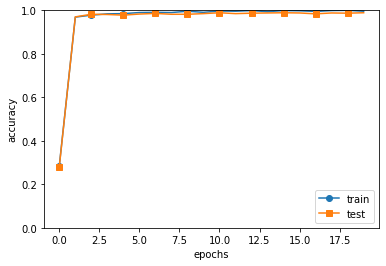

In [8]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()